In [2]:
import os
import pydicom
from tqdm import tqdm 
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.transforms.functional as F
from torchsummary import summary
import segmentation_models_pytorch as smp
import gc
import random
from ultralytics import YOLO
import wandb

/home/abk171/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [4]:
restructured_root = 'data_yolo'
image_dir = os.path.join(restructured_root, 'images')
image_train_dir = os.path.join(image_dir, 'train')
image_val_dir = os.path.join(image_dir, 'val')
image_test_dir = os.path.join(image_dir, 'test')
label_dir = os.path.join(restructured_root, 'labels')
label_train_dir = os.path.join(label_dir, 'train')
label_val_dir = os.path.join(label_dir, 'val')

In [5]:
anno_dir = '/data_vault/hexai02/CarpalTunnel/Annotations'
dicom_dir = '/data_vault/hexai02/CarpalTunnel/Images'

In [6]:
def load_mask(mask_path):
    mask = sitk.ReadImage(mask_path)
    return sitk.GetArrayFromImage(mask)[0][: 450, 200: 1300]

def load_dicom(dicom_path):
    dicom_data = pydicom.dcmread(dicom_path)
    return dicom_data.pixel_array[: 450, 200: 1300]

In [9]:
model = YOLO("yolo/yolov11 40 epochs2/weights/best.pt")
model.eval()
print('YOLO loaded')

YOLO loaded


In [10]:
train_images = []
train_masks = []
val_images = []
val_masks = []

def fill_arr(img_dir, img_bucket, mask_bucket):
    for jpg_name in tqdm(os.listdir(img_dir)): 
        img_filename = jpg_name.split('.')[0] + '.dcm'
        mask_filename = jpg_name.split('.')[0] + '.nii.gz'
        img = load_dicom(os.path.join(dicom_dir, img_filename))
        mask = load_mask(os.path.join(anno_dir, mask_filename))
        # img_bucket.append(img)
        # mask_bucket.append(mask)
        
        result = model(img, save=False, verbose=False)
        box = result[0].boxes
        # print(box.xyxy.tolist()[0])
        # break
        if len(box.xyxy.tolist())== 0:
            continue
        x1, y1, x2, y2 = map(int, box.xyxy.tolist()[0])
        img_bucket.append(img[y1:y2, x1:x2, 0])
        mask_bucket.append(mask[y1:y2, x1:x2])

# def fill_arr(img_dir, img_bucket,filetype='.dcm'):
#     for jpg_name in tqdm(os.listdir(img_dir)):
#         filename = jpg_name.split('.')[0] + filetype
#         img = load_dicom(os.path.join(dicom_dir, filename)) if filetype == '.dcm' else load_mask(os.path.join(anno_dir, filename))
#         img_bucket.append(img)

# fill_arr(image_train_dir, train_images)
# fill_arr(image_val_dir, val_images)
# fill_arr(label_train_dir, train_masks, filetype='.nii.gz')
# fill_arr(image_val_dir, val_masks, filetype='.nii.gz')

fill_arr(image_train_dir, train_images, train_masks)
fill_arr(image_val_dir, val_images, val_masks)

100%|█████████████████████| 19/19 [00:01<00:00, 10.39it/s]


In [11]:
print(len(train_images), len(val_images))

100 18


In [12]:
def plot_mosaic(img1, img2, img3, img4):
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))

    axes[0, 0].imshow(img1)
    axes[0, 0].axis('off')

    axes[0, 1].imshow(img2)
    axes[0, 1].axis('off')

    axes[1, 0].imshow(img3)
    axes[1, 0].axis('off')

    axes[1, 1].imshow(img4)
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

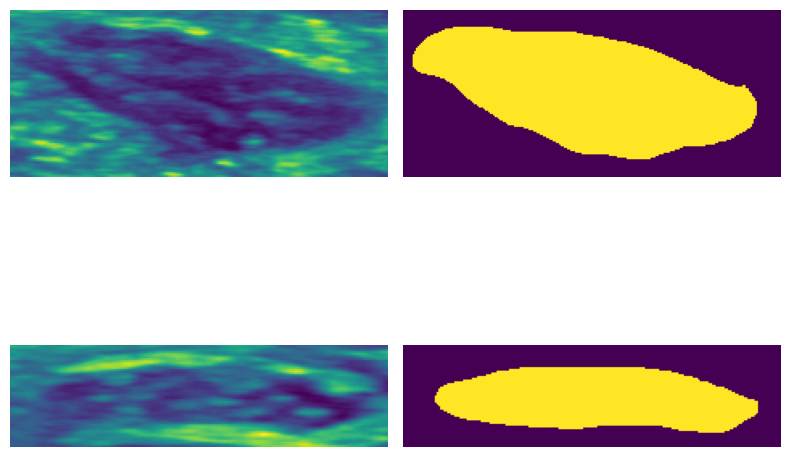

In [13]:
plot_mosaic(train_images[0], train_masks[0], val_images[0], val_masks[0])

In [14]:
class segmentationDataset(torch.utils.data.Dataset):
  """
  Dataset class for segmentation task.
  """
  def __init__(self, image_arr, seg_arr, split='train'):
    self.imgs = image_arr
    self.segs = seg_arr
    self.split = split


  def __len__(self):
    return len(self.imgs)


  def __getitem__(self, idx):
    img = torch.tensor(self.imgs[idx], dtype=torch.float32) / 255.0
    seg = torch.tensor(self.segs[idx])
    img = img.unsqueeze(0)
    seg = seg.unsqueeze(0)


    image_transform = T.Compose([
        T.Normalize(mean=[0.5], std=[0.5]),
        T.Resize((512, 512), interpolation=T.InterpolationMode.BILINEAR),
    ])

    mask_transform = T.Compose([
        T.Resize((512, 512), interpolation=T.InterpolationMode.NEAREST)  # Nearest-neighbor for masks
    ])

    train_transform = T.Compose([

        T.RandomErasing(p=0.5,scale=(0.02,0.1)),
        # T.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10)
    ])

    img = image_transform(img)
    seg = mask_transform(seg)

    if self.split == 'train':
        if random.random() < 0.5:
            img = F.hflip(img)
            seg = F.hflip(seg.to(torch.float32)).to(torch.uint16)
        angle = random.uniform(-10, 10)
        translate = (random.uniform(-0.1, 0.1) * img.shape[1], 
                     random.uniform(-0.1, 0.1) * img.shape[2])
        scale = random.uniform(0.9, 1.1)
        shear = random.uniform(-10, 10)

        img = F.affine(img, angle, translate, scale, shear, interpolation=T.InterpolationMode.BILINEAR)
        seg = F.affine(seg, angle, translate, scale, shear, interpolation=T.InterpolationMode.NEAREST)
        img = train_transform(img)
        # seg = train_transform(seg)
        
    return img, seg

    # return image_transform(img), mask_transform(seg)

In [15]:
train_dataset = segmentationDataset(train_images, train_masks)
val_dataset = segmentationDataset(val_images, val_masks, split='val')
train_dtl     = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    batch_size  = 32,
    shuffle     = True
)

val_dtl = torch.utils.data.DataLoader(
    dataset = val_dataset,
    batch_size = 32,
    shuffle = False
)

In [16]:
for i, data in enumerate(train_dtl):
    imgs_batch, segs_batch = data
    print(imgs_batch.shape)
    print(segs_batch.shape)
    break

torch.Size([32, 1, 512, 512])
torch.Size([32, 1, 512, 512])


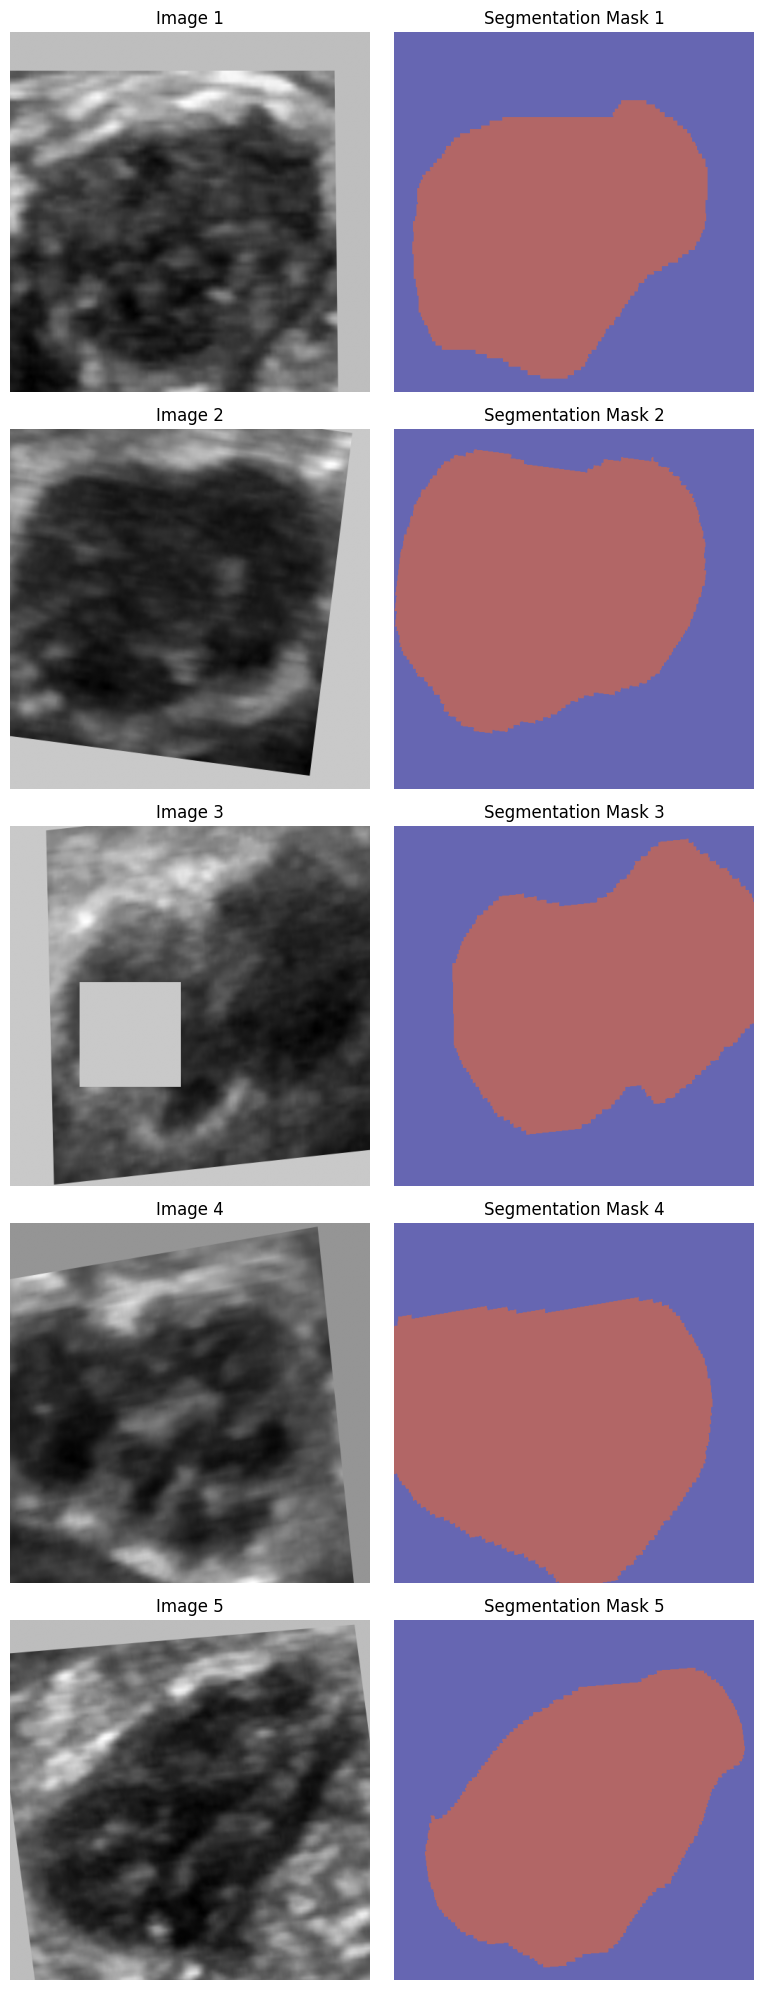

In [17]:


# Function to visualize a batch of images and segmentation masks
def visualize_batch(images, masks, num_samples=4):
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 4))
    
    for i in range(num_samples):
        img = images[i].squeeze().cpu().numpy()  # Convert to numpy and take the first channel
        mask = masks[i].squeeze().cpu().numpy()  # Convert to numpy and take the first channel

        # Normalize image for visualization
        img = (img - img.min()) / (img.max() - img.min())

        axes[i, 0].imshow(img, cmap="gray")
        axes[i, 0].set_title(f"Image {i+1}")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(mask, cmap="jet", alpha=0.6)
        axes[i, 1].set_title(f"Segmentation Mask {i+1}")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

visualize_batch(imgs_batch, segs_batch, num_samples=5)

In [18]:
import gc
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

In [19]:
config = {
    'epochs': 40,
    'in_channels': 1,
    'dropout': 0.2,
    'decoder_attention_type': 'scse',
    'init_lr': 5e-4,
    'weight_decay': 0.05,
    'T_max': 10,
    'eta_min': 3e-5
}

In [20]:
EPOCHS = config['epochs']
unet_model = smp.Unet(encoder_name="resnet18",in_channels=1,dropout=config['in_channels'],decoder_attention_type=config['decoder_attention_type']).to(device)

criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

optimizer = torch.optim.AdamW(unet_model.parameters(),
                              lr=config['init_lr'],
                              weight_decay=config['weight_decay'])

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max= config['T_max'],
        eta_min=config['eta_min'])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min', factor=0.7, patience=2,threshold=0.01, min_lr=config['eta_min'])

scaler = torch.cuda.amp.GradScaler()

/tmp/ipykernel_1829003/468507849.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [21]:
def save_model(model, optimizer, scheduler, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         'epoch'                    : epoch},
         path)


def load_model(model, optimizer=None, scheduler=None, path='./checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    return model, optimizer, scheduler, epoch

In [22]:
unet_root = 'unet_runs'
os.makedirs(unet_root, exist_ok=True)

In [23]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [24]:
def train_loop(dtl, model, criterion, optimzer, scheduler, scaler):
  model.train()
  loss_m = AverageMeter()
  batch_bar = tqdm(total=len(dtl), dynamic_ncols=True, leave=False, position=0, desc='Train')
  tps, fps, fns, tns = [], [], [], []
  for i, data in enumerate(dtl):

    imgs_batch, segs_batch = data
    imgs_batch = imgs_batch.to(device)
    segs_batch = segs_batch.to(device)

    with torch.cuda.amp.autocast():
      logits_masks = unet_model(imgs_batch)

      loss = criterion(logits_masks, segs_batch)

      prob_masks = logits_masks.sigmoid()
      pred_masks = (prob_masks > 0.5).float()

    scaler.scale(loss).backward()
    scaler.step(optimzer)
    scaler.update()

    tp, fp, fn, tn = smp.metrics.get_stats(pred_masks.long(), segs_batch.long(), mode="binary")
    tps.append(tp)
    fps.append(fp)
    fns.append(fn)
    tns.append(tn)
    loss_m.update(loss.item())

    batch_bar.set_postfix(
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

    batch_bar.update() # Update tqdm bar

  scheduler.step()
  print("Train loss: {:.04f}\t Learning rate: {:.04f}".format(loss_m.avg, float(optimizer.param_groups[0]['lr'])))
  tps = torch.cat(tps)
  fps = torch.cat(fps)
  fns = torch.cat(fns)
  tns = torch.cat(tns)

  per_image_iou = smp.metrics.iou_score(tps, fps, fns, tns, reduction="micro-imagewise")
  dataset_iou = smp.metrics.iou_score(tps, fps, fns, tns, reduction="micro")

  print("per image IOU: {:.04f}\nper dataset IOU: {:.04f}".format(per_image_iou, dataset_iou))
  return loss, per_image_iou, dataset_iou
    

In [25]:
def val_loop(dtl, model, criterion):
  model.eval()
  loss_m = AverageMeter()
  batch_bar = tqdm(total=len(dtl), dynamic_ncols=True, leave=False, position=0, desc='Validation')
  tps, fps, fns, tns = [], [], [], []
  for i, data in enumerate(dtl):

    imgs_batch, segs_batch = data
    imgs_batch = imgs_batch.to(device)
    segs_batch = segs_batch.to(device)

    with torch.inference_mode():
      logits_masks = unet_model(imgs_batch)

      loss = criterion(logits_masks, segs_batch)

      prob_masks = logits_masks.sigmoid()
      pred_masks = (prob_masks > 0.5).float()

    tp, fp, fn, tn = smp.metrics.get_stats(pred_masks.long(), segs_batch.long(), mode="binary")
    tps.append(tp)
    fps.append(fp)
    fns.append(fn)
    tns.append(tn)
    loss_m.update(loss.item())

    batch_bar.set_postfix(
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

    batch_bar.update() # Update tqdm bar

  print("Val loss: {:.04f}".format(loss_m.avg))
  tps = torch.cat(tps)
  fps = torch.cat(fps)
  fns = torch.cat(fns)
  tns = torch.cat(tns)

  per_image_iou = smp.metrics.iou_score(tps, fps, fns, tns, reduction="micro-imagewise")
  dataset_iou = smp.metrics.iou_score(tps, fps, fns, tns, reduction="micro")

  print("per image IOU: {:.04f}\nper dataset IOU: {:.04f}".format(per_image_iou, dataset_iou))

  return loss, per_image_iou, dataset_iou

In [26]:
gc.collect()
torch.cuda.empty_cache()

In [27]:
wandb.login(key="6e6412a1eff673cacdcda973f6e61422daaa9387")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/abk171/.netrc
wandb: Currently logged in as: abk171 (abk171-university-of-pittsburgh) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [28]:
run = wandb.init(
    name    = 'cropped images w resnet18 backbone  lower lr FINAL', ### Wandb creates random run names if you skip this field, we recommend you give useful names
    reinit  = True, ### Allows reinitalizing runs when you re-run this cell
    #id     = "y28t31uz", ### Insert specific run id here if you want to resume a previous run
    #resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "unet", ### Project should be created in your wandb account
    config  = config ### Wandb Config for your run
)

In [29]:
best_iou = 0
best_epoch = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1} / {EPOCHS}')
    train_loss, train_per_image_iou, train_dataset_iou = train_loop(train_dtl, unet_model, criterion, optimizer, scheduler, scaler)
    val_loss, val_per_image_iou, val_dataset_iou =val_loop(val_dtl, unet_model, criterion)
    wandb.log({'train_loss': train_loss, 'train_per_image_iou': train_per_image_iou, 'train_dataset_iou': train_dataset_iou,
               'val_loss': val_loss, 'val_per_image_iou': val_per_image_iou, 'val_dataset_iou': val_dataset_iou, 'lr': scheduler.get_last_lr()[0]})
    # scheduler.step(val_loss)
    if val_dataset_iou > best_iou:
        best_iou = val_dataset_iou
        best_epoch = epoch

    # save_model(unet_model, optimizer, scheduler, epoch, os.path.join(unet_root, f"epoch_{epoch+1}.pth"))
    torch.save(unet_model.state_dict(), os.path.join(unet_root, f"epoch_{epoch+1}.pth"))

Epoch 1 / 40


/tmp/ipykernel_1829003/3753527618.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                          

Train loss: 0.4280	 Learning rate: 0.0005
per image IOU: 0.5071
per dataset IOU: 0.5043


Val loss: 0.4705
per image IOU: 0.4682
per dataset IOU: 0.4738
Epoch 2 / 40


/tmp/ipykernel_1829003/3753527618.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                          

Train loss: 0.3305	 Learning rate: 0.0005
per image IOU: 0.7798
per dataset IOU: 0.7794


Val loss: 0.3893
per image IOU: 0.6827
per dataset IOU: 0.6815
Epoch 3 / 40


Train loss: 0.2868	 Learning rate: 0.0004
per image IOU: 0.8276
per dataset IOU: 0.8301


Val loss: 0.3443
per image IOU: 0.7533
per dataset IOU: 0.7550
Epoch 4 / 40


Train loss: 0.2616	 Learning rate: 0.0003
per image IOU: 0.8401
per dataset IOU: 0.8405


Val loss: 0.3012
per image IOU: 0.7247
per dataset IOU: 0.7252
Epoch 5 / 40


Train loss: 0.2481	 Learning rate: 0.0003
per image IOU: 0.8482
per dataset IOU: 0.8492


Val loss: 0.2686
per image IOU: 0.7445
per dataset IOU: 0.7431
Epoch 6 / 40


Train loss: 0.2348	 Learning rate: 0.0002
per image IOU: 0.8535
per dataset IOU: 0.8539


Val loss: 0.2402
per image IOU: 0.7892
per dataset IOU: 0.7905
Epoch 7 / 40


Train loss: 0.2302	 Learning rate: 0.0001
per image IOU: 0.8616
per dataset IOU: 0.8621


Val loss: 0.2278
per image IOU: 0.8032
per dataset IOU: 0.8042
Epoch 8 / 40


Train loss: 0.2207	 Learning rate: 0.0001
per image IOU: 0.8679
per dataset IOU: 0.8682


Val loss: 0.2232
per image IOU: 0.8333
per dataset IOU: 0.8346
Epoch 9 / 40


Train loss: 0.2105	 Learning rate: 0.0000
per image IOU: 0.8697
per dataset IOU: 0.8698


Val loss: 0.2452
per image IOU: 0.8095
per dataset IOU: 0.8088
Epoch 10 / 40


Train loss: 0.2142	 Learning rate: 0.0000
per image IOU: 0.8770
per dataset IOU: 0.8780


Val loss: 0.2479
per image IOU: 0.8091
per dataset IOU: 0.8091
Epoch 11 / 40


Train loss: 0.2058	 Learning rate: 0.0000
per image IOU: 0.8783
per dataset IOU: 0.8794


Val loss: 0.2483
per image IOU: 0.8095
per dataset IOU: 0.8097
Epoch 12 / 40


Train loss: 0.2091	 Learning rate: 0.0001
per image IOU: 0.8796
per dataset IOU: 0.8802


Val loss: 0.2355
per image IOU: 0.8273
per dataset IOU: 0.8280
Epoch 13 / 40


Train loss: 0.2084	 Learning rate: 0.0001
per image IOU: 0.8763
per dataset IOU: 0.8770


Val loss: 0.2239
per image IOU: 0.8378
per dataset IOU: 0.8394
Epoch 14 / 40


Train loss: 0.1997	 Learning rate: 0.0002
per image IOU: 0.8787
per dataset IOU: 0.8795


Val loss: 0.2347
per image IOU: 0.8210
per dataset IOU: 0.8223
Epoch 15 / 40


Train loss: 0.1958	 Learning rate: 0.0003
per image IOU: 0.8807
per dataset IOU: 0.8810


Val loss: 0.2446
per image IOU: 0.7871
per dataset IOU: 0.7888
Epoch 16 / 40


Train loss: 0.1939	 Learning rate: 0.0003
per image IOU: 0.8753
per dataset IOU: 0.8759


Val loss: 0.2081
per image IOU: 0.8386
per dataset IOU: 0.8388
Epoch 17 / 40


Train loss: 0.1847	 Learning rate: 0.0004
per image IOU: 0.8843
per dataset IOU: 0.8862


Val loss: 0.2018
per image IOU: 0.8236
per dataset IOU: 0.8266
Epoch 18 / 40


Train loss: 0.1718	 Learning rate: 0.0005
per image IOU: 0.8768
per dataset IOU: 0.8775


Val loss: 0.1911
per image IOU: 0.8173
per dataset IOU: 0.8171
Epoch 19 / 40


Train loss: 0.1773	 Learning rate: 0.0005
per image IOU: 0.8577
per dataset IOU: 0.8577


Val loss: 0.1854
per image IOU: 0.8214
per dataset IOU: 0.8220
Epoch 20 / 40


Train loss: 0.1618	 Learning rate: 0.0005
per image IOU: 0.8668
per dataset IOU: 0.8664


Val loss: 0.1737
per image IOU: 0.8202
per dataset IOU: 0.8190
Epoch 21 / 40


Train loss: 0.1522	 Learning rate: 0.0005
per image IOU: 0.8734
per dataset IOU: 0.8732


Val loss: 0.1508
per image IOU: 0.8432
per dataset IOU: 0.8440
Epoch 22 / 40


Train loss: 0.1432	 Learning rate: 0.0005
per image IOU: 0.8719
per dataset IOU: 0.8741


Val loss: 0.1541
per image IOU: 0.8390
per dataset IOU: 0.8369
Epoch 23 / 40


Train loss: 0.1403	 Learning rate: 0.0004
per image IOU: 0.8763
per dataset IOU: 0.8765


Val loss: 0.1676
per image IOU: 0.8135
per dataset IOU: 0.8100
Epoch 24 / 40


Train loss: 0.1321	 Learning rate: 0.0003
per image IOU: 0.8774
per dataset IOU: 0.8777


Val loss: 0.1464
per image IOU: 0.8416
per dataset IOU: 0.8400
Epoch 25 / 40


Train loss: 0.1249	 Learning rate: 0.0003
per image IOU: 0.8798
per dataset IOU: 0.8811


Val loss: 0.1320
per image IOU: 0.8581
per dataset IOU: 0.8591
Epoch 26 / 40


Train loss: 0.1249	 Learning rate: 0.0002
per image IOU: 0.8757
per dataset IOU: 0.8760


Val loss: 0.1333
per image IOU: 0.8500
per dataset IOU: 0.8518
Epoch 27 / 40


Train loss: 0.1177	 Learning rate: 0.0001
per image IOU: 0.8843
per dataset IOU: 0.8855


Val loss: 0.1312
per image IOU: 0.8503
per dataset IOU: 0.8506
Epoch 28 / 40


Train loss: 0.1177	 Learning rate: 0.0001
per image IOU: 0.8906
per dataset IOU: 0.8903


Val loss: 0.1335
per image IOU: 0.8451
per dataset IOU: 0.8450
Epoch 29 / 40


Train loss: 0.1178	 Learning rate: 0.0000
per image IOU: 0.8894
per dataset IOU: 0.8894


Val loss: 0.1338
per image IOU: 0.8453
per dataset IOU: 0.8454
Epoch 30 / 40


Train loss: 0.1121	 Learning rate: 0.0000
per image IOU: 0.8901
per dataset IOU: 0.8900


Val loss: 0.1323
per image IOU: 0.8501
per dataset IOU: 0.8504
Epoch 31 / 40


Train loss: 0.1095	 Learning rate: 0.0000
per image IOU: 0.8954
per dataset IOU: 0.8970


Val loss: 0.1320
per image IOU: 0.8519
per dataset IOU: 0.8522
Epoch 32 / 40


Train loss: 0.1114	 Learning rate: 0.0001
per image IOU: 0.8948
per dataset IOU: 0.8958


Val loss: 0.1327
per image IOU: 0.8503
per dataset IOU: 0.8505
Epoch 33 / 40


Train loss: 0.1069	 Learning rate: 0.0001
per image IOU: 0.8959
per dataset IOU: 0.8972


Val loss: 0.1285
per image IOU: 0.8581
per dataset IOU: 0.8581
Epoch 34 / 40


Train loss: 0.1070	 Learning rate: 0.0002
per image IOU: 0.8999
per dataset IOU: 0.9010


Val loss: 0.1269
per image IOU: 0.8586
per dataset IOU: 0.8586
Epoch 35 / 40


Train loss: 0.1068	 Learning rate: 0.0003
per image IOU: 0.8969
per dataset IOU: 0.8976


Val loss: 0.1345
per image IOU: 0.8422
per dataset IOU: 0.8428
Epoch 36 / 40


Train loss: 0.1103	 Learning rate: 0.0003
per image IOU: 0.8941
per dataset IOU: 0.8946


Val loss: 0.1370
per image IOU: 0.8313
per dataset IOU: 0.8305
Epoch 37 / 40


Train loss: 0.1030	 Learning rate: 0.0004
per image IOU: 0.8950
per dataset IOU: 0.8962


Val loss: 0.1315
per image IOU: 0.8339
per dataset IOU: 0.8339
Epoch 38 / 40


Train loss: 0.0991	 Learning rate: 0.0005
per image IOU: 0.8955
per dataset IOU: 0.8957


Val loss: 0.1218
per image IOU: 0.8525
per dataset IOU: 0.8538
Epoch 39 / 40


Train loss: 0.0937	 Learning rate: 0.0005
per image IOU: 0.8976
per dataset IOU: 0.8979


Val loss: 0.1249
per image IOU: 0.8413
per dataset IOU: 0.8413
Epoch 40 / 40


Train loss: 0.0949	 Learning rate: 0.0005
per image IOU: 0.8998
per dataset IOU: 0.9007


Val loss: 0.1312
per image IOU: 0.8272
per dataset IOU: 0.8254


In [30]:
run.finish()

lr,█▇▇▆▄▃▂▂▁▁▁▂▂▃▄▆▇▇███▇▇▆▄▃▂▂▁▁▁▂▂▃▄▆▇▇██
train_dataset_iou,▁▆▇▇▇▇▇▇▇█████████▇▇████████████████████
train_loss,█▇▆▅▅▅▅▅▄▅▄▅▅▄▄▄▄▃▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂
train_per_image_iou,▁▆▇▇▇▇▇▇▇█████████▇▇█▇██████████████████
val_dataset_iou,▁▅▆▆▆▇▇█▇▇▇▇█▇▇█▇▇▇▇██▇████████████▇███▇
val_loss,█▆▅▅▄▃▃▃▃▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_per_image_iou,▁▅▆▆▆▇▇█▇▇▇▇█▇▇█▇▇▇▇██▇████████████████▇
lr,0.0005
train_dataset_iou,0.90072
train_loss,0.10229
train_per_image_iou,0.89981


In [31]:
print(best_iou, best_epoch)

tensor(0.8591, device='cuda:0') 24


In [32]:
unet_model.eval()
with torch.inference_mode():
    for img, seg in val_dtl:
        img = img.to(device)
        seg = seg.to(device)

        results = unet_model(img)
        break

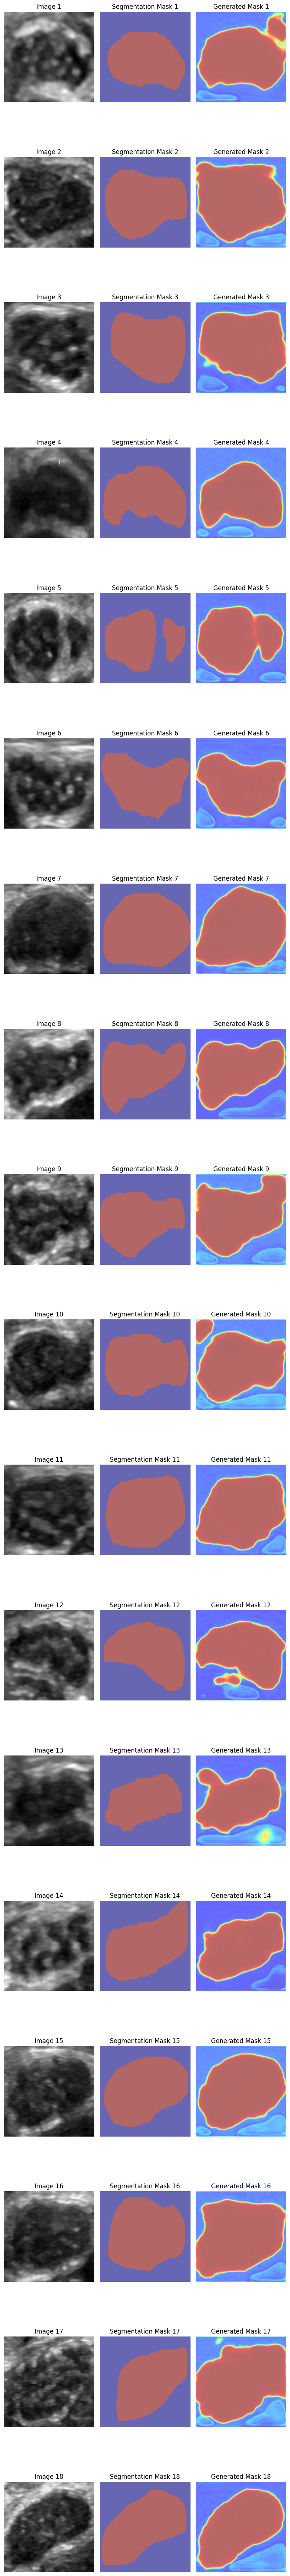

In [38]:
# Function to visualize a batch of images and segmentation masks
def visualize_batch(images, masks, gen_masks, num_samples=4):
    fig, axes = plt.subplots(num_samples, 3, figsize=(8, num_samples * 4))
    
    for i in range(num_samples):
        img = images[i].squeeze().cpu().numpy()  # Convert to numpy and take the first channel
        mask = masks[i].squeeze().cpu().numpy()  # Convert to numpy and take the first channel
        gen_mask = gen_masks[i].squeeze().cpu().numpy()

        # Normalize image for visualization
        img = (img - img.min()) / (img.max() - img.min())

        axes[i, 0].imshow(img, cmap="gray")
        axes[i, 0].set_title(f"Image {i+1}")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(mask, cmap="jet", alpha=0.6)
        axes[i, 1].set_title(f"Segmentation Mask {i+1}")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(gen_mask, cmap="jet", alpha=0.6)
        axes[i, 2].set_title(f"Generated Mask {i+1}")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

visualize_batch(img, seg, results, num_samples=18)